In [1]:
from thesis_tools.utils.data import *
# Read data
df = read_billionaires_data()
# filter US 2018
df = df[(df['country_of_citizenship'] == 'United States') & (df['year'] == '2018')]
df['excesses'] = df['net_worth'] - 1
Y = df['net_worth'].values

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# docs: https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.CustomDist.html

In [4]:
from thesis_tools.models.frequentist import GeneralisedPareto

In [5]:
model_gpd = pm.Model()

with model_gpd:
    mu = 1
    sigma = pm.Gamma('sigma', alpha=1, beta=1)
    gamma = pm.Uniform('gamma', lower=0, upper=1)

    def gpd_logp(value, mu, sigma, gamma):
        if gamma == 0:
            return -np.log(sigma) - (value - mu)/sigma
        else:
            return -np.log(sigma) - (1 + 1/gamma) * np.log(1 + gamma * (value - mu)/sigma)

    def random(mu: np.ndarray, sigma, gamma, rng=None, size=None):
        # generate uniforms
        u = rng.uniform(size=size)
        if gamma == 0:
            return mu - sigma * np.log(1-u)
        else:
            return mu + sigma * ((1 / (1 - u)**gamma - 1)) / gamma

    Y_gpd = pm.CustomDist('Y_gpd', mu, sigma, gamma, logp=gpd_logp, random=random, observed=Y)
    

In [6]:
with model_gpd:
    trace_gpd = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

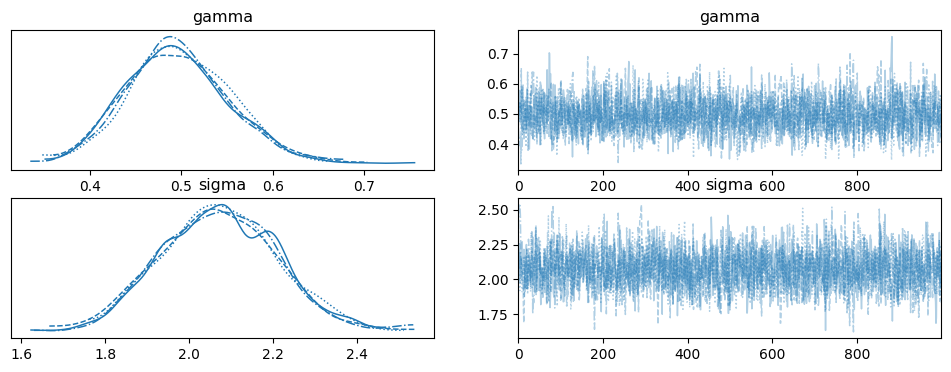

In [ ]:
az.plot_trace(trace_gpd)

In [ ]:
# Posterior predictive
with model_gpd:
    ppc = pm.sample_prior_predictive()

Sampling: [Y_gpd, gamma, sigma]


In [ ]:
ppc

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [ ]:
prior_Y = ppc.prior_predictive['Y_gpd'].values.flatten()

(1.0, 100.0)

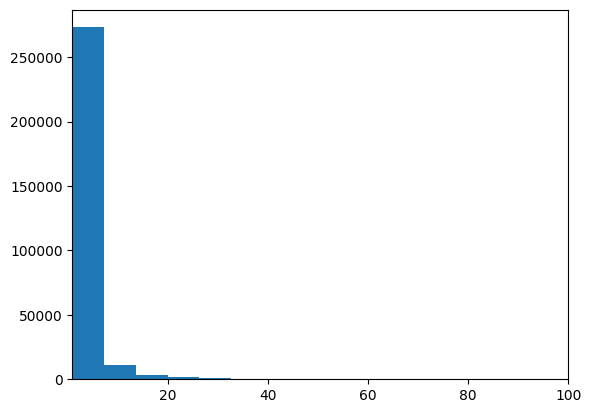

In [ ]:
# hsitogram of prior_Y
plt.hist(prior_Y, bins=1000)
plt.xlim(1, 100)

In [ ]:
with model_gpd:
    ppc = pm.sample_posterior_predictive(trace_gpd)

Sampling: [Y_gpd]


Output()

In [ ]:
Y_posterior = ppc.posterior_predictive['Y_gpd'].values.flatten()

In [ ]:
log_Y_posterior = np.log(Y_posterior)

(array([17.,  0., 21., 15.,  0., 21.,  0., 18., 17., 22.,  0., 19.,  9.,
         6., 24., 11., 16., 10.,  8., 23., 11., 26.,  9., 24., 13., 17.,
         8., 16., 13., 16., 18.,  7.,  8., 18., 10.,  6., 13.,  9.,  4.,
         7.,  2.,  2.,  5.,  4.,  5.,  4.,  3.,  3.,  2.,  1.,  1.,  2.,
         0.,  2.,  4.,  4.,  1.,  1.,  2.,  2.,  1.,  0.,  1.,  4.,  0.,
         1.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  4.,  2.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.04718499, 0.09436998, 0.14155497, 0.18873995,
        0.23592494, 0.28310993, 0.33029492, 0.37747991, 0.4246649 ,
        0.47184989, 0.51903488, 0.56621986, 0.61340485, 0.66058984,
        0.70777483, 0.75495982, 0.80214481, 0.8493298 , 0.89651479,
        0.94369977, 0.99088476, 1.03806975, 1.08525474, 1.13243973,
        1.17962472, 1.22680971, 1.2739947 , 1.32117968, 1.36836467,
        1.41554966, 1.4627

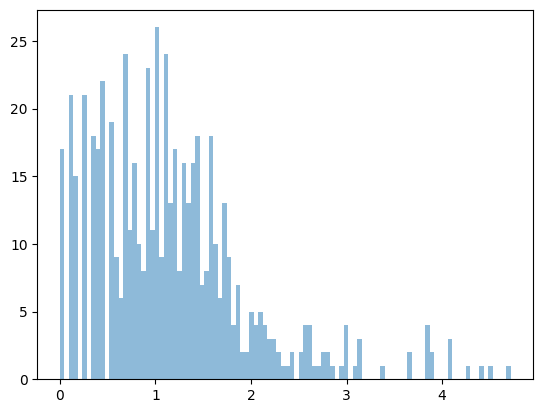

In [ ]:
# Plot
plt.hist(np.log(Y), bins=100, alpha=0.5, label='Data')

In [ ]:
# Plot